


# Part 1: Data Preprocessing

## Import Libraries and Data

In [ ]:
!pip install pandas_plink
!pip install mrmr-selection

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
# For data preprocessing
import pandas as pd
import numpy as np
from pandas_plink import read_plink1_bin # for reading in PLINK binary file set
import mrmr # for feature selection

# For data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

# for model building
import tensorflow as tf


In [ ]:
fPATH_ADNI_Omni25M = '/content/drive/MyDrive/ADV_DS/ADNI_GENETIC_DATA/ADNI_Omni25M/microarray_SNP_data/WGS_Omni25_BIN.bed'
fPATH_INFO= '/content/drive/MyDrive/ADV_DS/ADNI_GENETIC_DATA/ADNI_Omni25M/ADNI_Deletions_Radke/ADNI_IDinfo.txt'

In [ ]:
DF_idInfo = pd.read_csv(fPATH_INFO, delimiter='\t', usecols=['ADNI_PTID', 'pheno'])
data0 = read_plink1_bin(fPATH_ADNI_Omni25M)

Mapping files: 100%|██████████| 3/3 [00:08<00:00,  2.84s/it]


## Data Cleaning



In [ ]:
iid_arr = data0.sample['iid'].values

#find the missing patient ids.
setOf_dFrame_ptids = set(DF_idInfo['ADNI_PTID'])
setOf_dArray_ptids = set(iid_arr)
missing_ids = setOf_dArray_ptids - setOf_dFrame_ptids
missing_ids = np.array(list(missing_ids))
print(f'Missing Patient Ids:', missing_ids)

# sort the dataArray and the idinfo dataframe
sorted_dArray = data0.sortby('iid')
sorted_df = DF_idInfo.sort_values(by='ADNI_PTID')


#drop missing patients from the sorted data array
drop_set = set(missing_ids)
mask = np.array([iid not in drop_set for iid in sorted_dArray.sample['iid'].values])
resized_dArray = sorted_dArray.sel(sample=mask)

# replace the empty trait values with the new pheno values from the idInfo dataframe
resized_dArray.trait.values = sorted_df['pheno'].to_numpy()
data0 = resized_dArray

# drop variants with missing genotypes for any single patient:
data0 = data0.dropna(dim='variant', how='any')
data0

Missing Patient Ids: ['023_S_0376' '012_S_1212' '137_S_4536' '035_S_0292']


<xarray.DataArray 'genotype' (sample: 808, variant: 1509435)>
dask.array<getitem, shape=(808, 1509435), dtype=float32, chunksize=(808, 741), chunktype=numpy.ndarray>
Coordinates: (12/14)
  * sample   (sample) object '002_S_0413' '002_S_0685' ... '941_S_4420'
  * variant  (variant) <U14 'variant3' 'variant12' ... 'variant2379852'
    fid      (sample) object '199' '702' '57' '158' ... '389' '248' '253' '534'
    iid      (sample) object '002_S_0413' '002_S_0685' ... '941_S_4420'
    father   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    mother   (sample) object '0' '0' '0' '0' '0' '0' ... '0' '0' '0' '0' '0' '0'
    ...       ...
    chrom    (variant) object '0' '0' '0' '0' '0' ... '26' '26' '26' '26' '26'
    snp      (variant) object 'rs35144699' 'rs10085382' ... 'MitoG16393A'
    cm       (variant) float64 0.0 0.0 0.0 0.0 0.0 ... 100.0 100.0 100.0 100.0
    pos      (variant) int32 0 0 0 0 0 0 ... 15925 15931 16052 16272 16329 16393
    a0       (variant) object 'T' 'C' 'A' '0' '0' '0' ... 'A' 'G' 'T' 'T' 'A'
    a1       (variant) object 'A' 'T' 'G' 'G' 'C' 'C' ... 'G' 'A' 'C' 'C' 'G'

## Feature Selection With MRMR algorithm

In [ ]:
# selection of features via minimum redundancy maximum relavence.
def mrmr_feature_selection(features: pd.DataFrame, labels: pd.Series, n: int) -> np.array:
  # n is the number of parts the feature dataframe is spliced into before doing
  # performing mrmr algorithm on each part.

  q = (features.shape[1]//n)
  vars = list()
  i = 0

  while i < (n-1):
    a = features.iloc[:,i*q:(i+1)*q]
    temp = mrmr.mrmr_classif(X=a, y=labels, K=10)
    vars.append(temp)
    i+=1

  i+=1
  a = features.iloc[:, i*q:features.shape[1]] # to make sure all features in the data set are included
  temp = mrmr.mrmr_classif(X=a, y=labels, K=10)
  vars.append(temp)
  vars = np.array(vars)
  vars = vars.flatten()

  return vars # k*n = the total number of features selected.


In [ ]:
df = data0.to_pandas()
df = df.rename_axis(index=None, columns=None)
df = df.reset_index(drop=True)

labels = data0.trait.to_pandas()
labels = labels.rename_axis(index=None)
labels = labels.reset_index(drop=True)


In [ ]:
selected_features = mrmr_feature_selection(features=df, labels=labels, n=50)

In [ ]:
data1 = data0.sel(variant=selected_features)
mrmr_df = data1.to_pandas()

mrmr_df = mrmr_df.rename_axis(index=None, columns=None)
mrmr_df = mrmr_df.reset_index(drop=True)

In [ ]:
# saving the features to a csv so that I will not need to open the full dataset again.
#mrmr_df.to_csv('/content/drive/MyDrive/ADV_DS/mrmr_features.csv')

<hr>
<br>


# Part 2: Data Exploration

## Data Exploration

In [ ]:
#!pip install pandas_plink
!pip install mrmr-selection

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.8 MB/s eta 0:00:00


In [ ]:

# For data preprocessing
import pandas as pd
import numpy as np
#from pandas_plink import read_plink1_bin # for reading in PLINK binary file set
import mrmr # for feature selection

# For data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure

# for model building
import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
# saved to folder so i never have to sit through that again
path_mrmr_features = '/content/drive/MyDrive/ADV_DS/mrmr_features.csv'
fPATH_INFO= '/content/drive/MyDrive/ADV_DS/ADNI_GENETIC_DATA/ADNI_Omni25M/ADNI_Deletions_Radke/ADNI_IDinfo.txt'


In [ ]:
df = pd.read_csv(path_mrmr_features, index_col=False)
df.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
DF_idInfo = pd.read_csv(fPATH_INFO, delimiter='\t', usecols=['ADNI_PTID', 'pheno'])
labels = DF_idInfo['pheno']

In [ ]:
selected_features, relevance_scores_, redundancy_matrix = mrmr.mrmr_classif(X=df, y=labels, return_scores=True, K=50)

100%|██████████| 50/50 [00:10<00:00,  4.83it/s]


<Axes: >

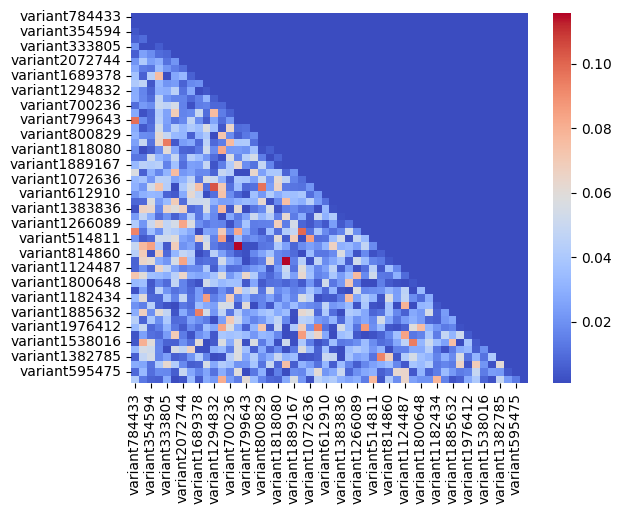

In [ ]:
sns.heatmap(redundancy_matrix[selected_features].loc[selected_features], cmap='coolwarm')

In [ ]:
rel_array = np.asarray(relevance_scores_[selected_features])

In [ ]:
# get the interesting half of the heatmap
lower_diagonal = np.tril(redundancy_matrix[selected_features].loc[selected_features])
flattened_diagonal = lower_diagonal.flatten()[lower_diagonal.flatten() != 0]
red_array = flattened_diagonal

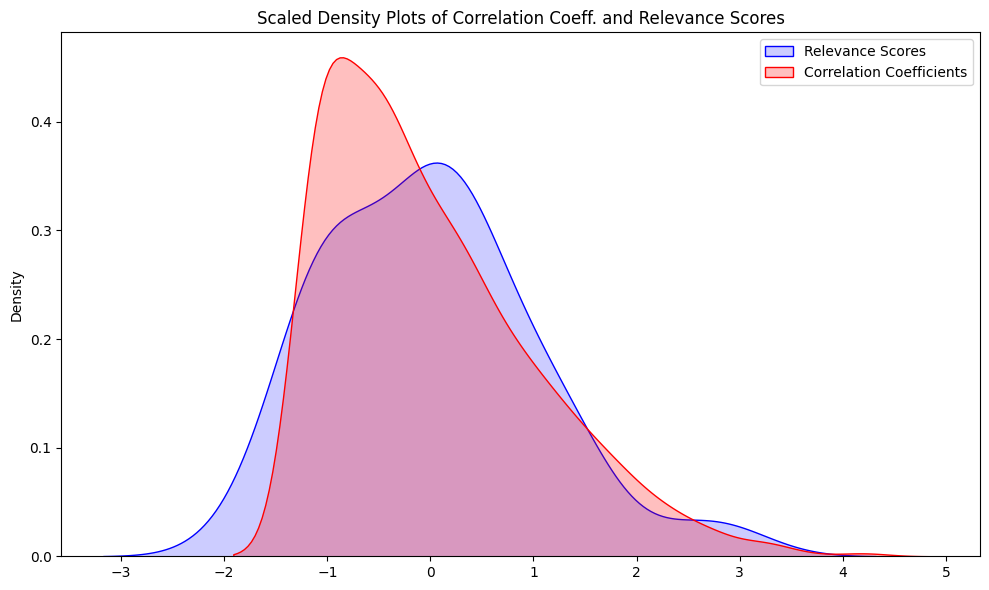

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rel_scaled = scaler.fit_transform(rel_array.reshape(-1, 1)).flatten()
red_scaled = scaler.fit_transform(red_array.reshape(-1,1)).flatten()


plt.figure(figsize=(10, 6))
sns.kdeplot(data=rel_scaled, shade=True, color='blue', alpha=0.2, label='Relevance Scores')
plt.xlabel('')
plt.ylabel('Density')
plt.title('Scaled Density Plots of Correlation Coeff. and Relevance Scores')
sns.kdeplot(data=red_scaled, shade=True, color='red', label='Correlation Coefficients')
plt.tight_layout()
plt.legend()
plt.show()

<hr>
<br>


# Part 3: Modeling

## Models With set of 50 mRMR features





In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(df[selected_features], labels, test_size=0.2, random_state=42)

NameError: name 'selected_features' is not defined

### SVM Classification

In [ ]:
# Define parameter grid
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold, GridSearchCV
from sklearn.metrics import classification_report

param_grid = {
  'C': [.001, 0.1, 1, 10, 100],
  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
  'kernel': ['rbf', 'poly', 'linear', 'sigmoid']
}


#define Grid searchCV for hyperparameter fine tuning
search = GridSearchCV(SVC(), param_grid, scoring='accuracy', n_jobs=-1, cv=2)# Perform random search

result = search.fit(xtrain, ytrain)
# Get best parameters and best accuracy
best_params = result.best_params_
best_accuracy = result.best_score_

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.5046439628482973
Best Hyperparameters: {'C': 0.001, 'gamma': 0.1, 'kernel': 'poly'}


In [ ]:
model_opt = result.best_estimator_
model_opt.fit(xtrain, ytrain)

SVC(C=0.001, gamma=0.1, kernel='poly')

In [ ]:
# SVM Model Results
y_pred = model_opt.predict(xtest)

In [ ]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           1       0.50      0.38      0.43        53
           2       0.50      0.72      0.59        72
           3       0.41      0.19      0.26        37

    accuracy                           0.49       162
   macro avg       0.47      0.43      0.43       162
weighted avg       0.48      0.49      0.46       162



Model is overfitting so lets try again with a higher regularization param
best parameters according to GridSearch { 'C': 1000, 'gamma': 1, 'kernel': 'linear' }

In [ ]:
model = SVC(C=.001, gamma=1, kernel='poly', degree=5)
f = model.fit(xtrain, ytrain)
y_pred = f.predict(xtest)


In [ ]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           1       0.45      0.43      0.44        53
           2       0.50      0.50      0.50        72
           3       0.41      0.43      0.42        37

    accuracy                           0.46       162
   macro avg       0.45      0.46      0.45       162
weighted avg       0.46      0.46      0.46       162



After playing around with the values myself, I believe that gridsearch is likely not working correctly due to the small sample size of the training data. This could possibly be due to the way I use Repeated Kfold to determine CV. I recognized that there was an issue due to the large regularization parameter.

<hr>

### Gaussian Naive **Bayes**

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
nb_classifier = GaussianNB()

nb_classifier.fit(xtrain, ytrain)

y_pred = nb_classifier.predict(xtest)

In [ ]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           1       0.48      0.64      0.55        53
           2       0.58      0.51      0.54        72
           3       0.37      0.27      0.31        37

    accuracy                           0.50       162
   macro avg       0.48      0.48      0.47       162
weighted avg       0.50      0.50      0.49       162



###  Multi-nomial Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
param_grid = {
    'C': [.001, .01, .1, 10, 100],
    'multi_class': ['multinomial'],
    'solver': ['lbfgs','sag', 'saga', 'newton-cg'], # for multinomial classification only
    'penalty': ['l1', 'l2']
  }

# initialize model
lr = LogisticRegression(max_iter=100)



# define Grid searchCV for hyperparameter fine tuning
search = GridSearchCV(lr, param_grid, scoring='accuracy', n_jobs=-1, cv=2)

result = search.fit(xtrain, ytrain)


print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.5046439628482973
Best Hyperparameters: {'C': 0.1, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'saga'}


In [ ]:
#'C': 0.1, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'saga'

In [ ]:
model = LogisticRegression(C=.1, multi_class='multinomial', penalty='l2', solver='saga')
f = model.fit(xtrain, ytrain)
y_pred = f.predict(xtest)
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           1       0.45      0.36      0.40        53
           2       0.48      0.65      0.56        72
           3       0.35      0.22      0.27        37

    accuracy                           0.46       162
   macro avg       0.43      0.41      0.41       162
weighted avg       0.44      0.46      0.44       162



In [ ]:
model = LogisticRegression(C=.01, multi_class='multinomial', penalty='l2', solver='sag')
f = model.fit(xtrain, ytrain)
y_pred = f.predict(xtest)
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           1       0.54      0.28      0.37        53
           2       0.48      0.86      0.62        72
           3       0.40      0.05      0.10        37

    accuracy                           0.49       162
   macro avg       0.47      0.40      0.36       162
weighted avg       0.48      0.49      0.42       162



In [ ]:
model = LogisticRegression(C=.01, multi_class='multinomial', penalty='l2', solver='lbfgs')
f = model.fit(xtrain, ytrain)
y_pred = f.predict(xtest)
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           1       0.54      0.28      0.37        53
           2       0.48      0.86      0.62        72
           3       0.40      0.05      0.10        37

    accuracy                           0.49       162
   macro avg       0.47      0.40      0.36       162
weighted avg       0.48      0.49      0.42       162



### Convolutional Neural Network

In [ ]:
data = df[selected_features].to_numpy()
data = to_categorical(data)

In [ ]:
data = data.reshape(808,5,10,3)

In [ ]:
labels-=1
l=to_categorical(labels)

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(data, l, test_size=.2)

In [ ]:
xtrain.shape

(646, 5, 10, 3)

In [ ]:
dropout = .01
lr = .90
# Define input shape
# Create a Sequential model
input_shape = (5,10,3)
model = Sequential()

model.add(Input(shape=input_shape))

model.add(Conv2D(20, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=dropout))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=dropout))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(1, 2)))
model.add(Dropout(rate=dropout))

# Flatten layer to convert 2D feature maps into a 1D vector
model.add(Flatten())
# Output layer
model.add(Dense(3, activation='softmax'))

# Compile the model
with tf.device('/GPU:0'):
  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
model.summary()


Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_356 (Conv2D)         (None, 5, 10, 20)         560       
                                                                 
 max_pooling2d_237 (MaxPool  (None, 2, 5, 20)          0         
 ing2D)                                                          
                                                                 
 dropout_241 (Dropout)       (None, 2, 5, 20)          0         
                                                                 
 conv2d_357 (Conv2D)         (None, 2, 5, 32)          5792      
                                                                 
 max_pooling2d_238 (MaxPool  (None, 1, 2, 32)          0         
 ing2D)                                                          
                                                                 
 dropout_242 (Dropout)       (None, 1, 2, 32)        

In [ ]:
with tf.device('/GPU:0'):
  model.fit(xtrain, ytrain, epochs=300, batch_size=50)

Epoch 1/300
13/13 [==============================] - 3s 50ms/step - loss: 12583.7969 - accuracy: 0.3901
Epoch 2/300
13/13 [==============================] - 0s 4ms/step - loss: 1.2017 - accuracy: 0.3622
Epoch 3/300
13/13 [==============================] - 0s 4ms/step - loss: 1.1285 - accuracy: 0.4381
Epoch 4/300
13/13 [==============================] - 0s 4ms/step - loss: 1.1176 - accuracy: 0.3824
Epoch 5/300
13/13 [==============================] - 0s 4ms/step - loss: 1.0777 - accuracy: 0.4195
Epoch 6/300
13/13 [==============================] - 0s 4ms/step - loss: 1.0792 - accuracy: 0.4009
Epoch 7/300
13/13 [==============================] - 0s 4ms/step - loss: 1.0732 - accuracy: 0.4303
Epoch 8/300
13/13 [==============================] - 0s 4ms/step - loss: 1.0769 - accuracy: 0.4551
Epoch 9/300
13/13 [==============================] - 0s 4ms/step - loss: 1.0810 - accuracy: 0.4195
Epoch 10/300
13/13 [==============================] - 0s 4ms/step - loss: 1.0734 - accuracy: 0.4118
Epoc

In [ ]:
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
y = model.predict(xtest)

yp = [np.argmax(y[i]) for i in range(len(y))]
yp = to_categorical(yp, num_classes=3)
accuracy_score(y_true=ytest, y_pred=yp)

6/6 [==============================] - 1s 167ms/step


0.4691358024691358

## Models with Set of 500 Mrmr Features

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(df, labels, test_size=0.2, random_state=42)

### SVM Classification

In [ ]:
# Define parameter grid
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold, GridSearchCV
from sklearn.metrics import classification_report

param_grid = {
  'C': [0.1, 1, 10, 100, 1000],
  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
  'kernel': ['rbf', 'poly', 'linear', 'sigmoid']
}


#define Grid searchCV for hyperparameter fine tuning
search = GridSearchCV(SVC(), param_grid, scoring='accuracy', n_jobs=-1, cv=2)# Perform random search

result = search.fit(xtrain, ytrain)
# Get best parameters and best accuracy
best_params = result.best_params_
best_accuracy = result.best_score_

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.45975232198142413
Best Hyperparameters: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


In [ ]:
model_opt = result.best_estimator_
model_opt.fit(xtrain, ytrain)

SVC(C=0.1, gamma=1)

In [ ]:
y_pred = model_opt.predict(xtest)

In [ ]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        53
           2       0.44      1.00      0.62        72
           3       0.00      0.00      0.00        37

    accuracy                           0.44       162
   macro avg       0.15      0.33      0.21       162
weighted avg       0.20      0.44      0.27       162



In [ ]:
model = SVC(C=.01, gamma=1, kernel='poly')
f = model.fit(xtrain, ytrain)
y_pred = f.predict(xtest)


In [ ]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           1       0.31      0.34      0.32        53
           2       0.48      0.46      0.47        72
           3       0.24      0.22      0.23        37

    accuracy                           0.36       162
   macro avg       0.34      0.34      0.34       162
weighted avg       0.37      0.36      0.36       162



Not really learning!

### Gausian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
nb_classifier = GaussianNB()

nb_classifier.fit(xtrain, ytrain)

y_pred = nb_classifier.predict(xtest)

In [ ]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           1       0.37      0.13      0.19        53
           2       0.41      0.24      0.30        72
           3       0.21      0.57      0.30        37

    accuracy                           0.28       162
   macro avg       0.33      0.31      0.27       162
weighted avg       0.35      0.28      0.27       162



### Multi-nomial Logistic Regression

In [ ]:
# Define parameter grid
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold, GridSearchCV
from sklearn.metrics import classification_report

param_grid = {
    'C': [.001, .01, .1, 10, 100],
    'multi_class': ['multinomial'],
    'solver': ['lbfgs','sag', 'saga', 'newton-cg'], # for multinomial classification only
    'penalty': ['l1', 'l2']
  }

lr = LogisticRegression(max_iter=100)

#define Grid searchCV for hyperparameter fine tuning
search = GridSearchCV(lr, param_grid, scoring='accuracy', n_jobs=-1)# Perform random search

result = search.fit(xtrain, ytrain)
# Get best parameters and best accuracy
best_params = result.best_params_
best_accuracy = result.best_score_

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.45976147883124624
Best Hyperparameters: {'C': 0.001, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga'}


In [ ]:
best_fit = result.best_estimator_.fit(xtrain,ytrain)
y_pred = best_fit.predict(xtest)
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        53
           2       0.44      1.00      0.62        72
           3       0.00      0.00      0.00        37

    accuracy                           0.44       162
   macro avg       0.15      0.33      0.21       162
weighted avg       0.20      0.44      0.27       162



In [ ]:
model = LogisticRegression(max_iter=10000, C=.1, multi_class='multinomial', penalty='l2', solver='saga')
best_fit =model.fit(xtrain,ytrain)

In [ ]:
y_pred = best_fit.predict(xtest)
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           1       0.29      0.26      0.28        53
           2       0.47      0.54      0.50        72
           3       0.19      0.16      0.18        37

    accuracy                           0.36       162
   macro avg       0.32      0.32      0.32       162
weighted avg       0.35      0.36      0.35       162



<hr>
<br>

### Convulutional Neural Network

In [ ]:
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
s = to_categorical(df)
traits = {'trait': np.asarray(labels)}
traits = pd.DataFrame(traits)

In [ ]:
traits.shape

(808, 1)

In [ ]:
df.shape

(808, 500)

In [ ]:
tdf = pd.concat([traits, df], axis=1)

In [ ]:
tdf

,trait,variant19162,variant29244,variant41665,variant25562,...,variant2379797,variant2379780,variant2379767,variant2379804,variant2379803
0,3,0.0,1.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0
1,2,1.0,2.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0
2,3,2.0,1.0,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0
3,3,1.0,1.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0
4,1,2.0,1.0,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
803,2,0.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0
804,3,2.0,2.0,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0
805,2,2.0,1.0,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0
806,1,2.0,1.0,2.0,1.0,...,2.0,2.0,2.0,2.0,2.0


Lets see what happens when we give the model genetic data reshaped to look like images.

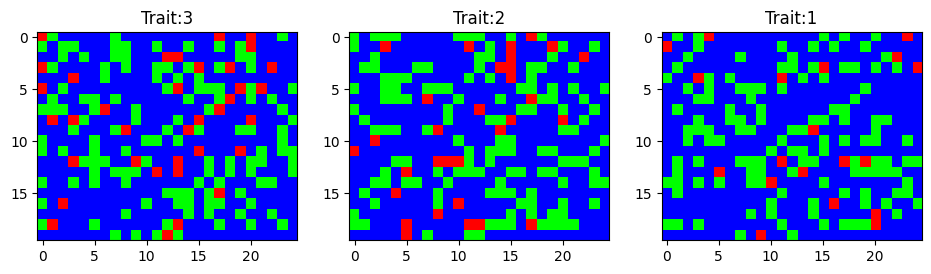

In [ ]:
# get one of each trait:
t123 = [0, 1, 4]
sample = df.loc[t123]
sImgs = to_categorical(sample)
sImgs = sImgs.reshape(3, 20, 25, 3)

plt.figure(figsize=(100,300))
for i in range(0,3):
  plt.subplot(20, 25, i+1)
  plt.imshow(sImgs[i])
  plt.title(('Trait:' + str(tdf['trait'].loc[t123[i]])))

In [ ]:
encoded_variants = to_categorical(df)


In [ ]:
adj = labels-1
encoded_labels = to_categorical(adj)
encoded_labels.shape

(808, 3)

In [ ]:
data = encoded_variants.reshape(808, 20,25,3)

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(data, encoded_labels, test_size=.2)

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import numpy as np
import os
from tensorflow import keras
from keras.optimizers import Adam
from keras import Sequential
import keras_tuner
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
dropout = .001
lr = 1
# Define input shape
# Create a Sequential model
input_shape = (20,25,3)
model = Sequential()

model.add(Input(shape=input_shape))

# Add Convolutional layers with larger kernel sizes and 'same' padding
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))

model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(rate=dropout))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(rate=dropout))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=dropout))

# Flatten layer to convert 2D feature maps into a 1D vector
model.add(Flatten())
# Output layer
model.add(Dense(3, activation='softmax'))

# Compile the model
with tf.device('/GPU:0'):
  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
model.summary()

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_310 (Conv2D)         (None, 20, 25, 32)        896       
                                                                 
 max_pooling2d_202 (MaxPool  (None, 6, 8, 32)          0         
 ing2D)                                                          
                                                                 
 dropout_208 (Dropout)       (None, 6, 8, 32)          0         
                                                                 
 conv2d_311 (Conv2D)         (None, 6, 8, 64)          18496     
                                                                 
 conv2d_312 (Conv2D)         (None, 6, 8, 64)          36928     
                                                                 
 conv2d_313 (Conv2D)         (None, 6, 8, 64)          36928     
                                                     

In [ ]:
model.fit(xtrain, ytrain, epochs=100, batch_size=10)

Epoch 1/100
65/65 [==============================] - 0s 4ms/step - loss: 1.1578 - accuracy: 0.3963
Epoch 2/100
65/65 [==============================] - 0s 4ms/step - loss: 1.1929 - accuracy: 0.3994
Epoch 3/100
65/65 [==============================] - 2s 30ms/step - loss: 1.1179 - accuracy: 0.4056
Epoch 4/100
65/65 [==============================] - 1s 9ms/step - loss: 1.1411 - accuracy: 0.3808
Epoch 5/100
65/65 [==============================] - 0s 4ms/step - loss: 1.1147 - accuracy: 0.4211
Epoch 6/100
65/65 [==============================] - 0s 4ms/step - loss: 1.1444 - accuracy: 0.4257
Epoch 7/100
65/65 [==============================] - 0s 4ms/step - loss: 1.1667 - accuracy: 0.3978
Epoch 8/100
65/65 [==============================] - 0s 4ms/step - loss: 1.1266 - accuracy: 0.4025
Epoch 9/100
65/65 [==============================] - 3s 51ms/step - loss: 1.1428 - accuracy: 0.4164
Epoch 10/100
65/65 [==============================] - 0s 4ms/step - loss: 1.1573 - accuracy: 0.3932
Epoch 1

In [ ]:
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
y = model.predict(xtest)

yp = [np.argmax(y[i]) for i in range(len(y))]
yp = to_categorical(yp, num_classes=3)
accuracy_score(y_true=ytest, y_pred=yp)


6/6 [==============================] - 0s 2ms/step


0.4444444444444444

0.4444444444444444

In [ ]:
tuner.get_best_hyperparameters

In [ ]:
p = best_model.predict(xtest)

6/6 [==============================] - 0s 3ms/step


In [ ]:
y = [np.argmax(p[i]) for i in range(len(p))]

In [ ]:
yp=to_categorical(y)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=ytest, y_pred=yp))

              precision    recall  f1-score   support

           0       0.26      0.16      0.20        56
           1       0.45      0.60      0.51        77
           2       0.20      0.17      0.19        29

   micro avg       0.37      0.37      0.37       162
   macro avg       0.30      0.31      0.30       162
weighted avg       0.34      0.37      0.35       162
 samples avg       0.37      0.37      0.37       162



In [ ]:
p

85